# Example 2b: Optical constant models

We may want to model the optical constants of a material using analytic expressions, rather than just take data from a
table; this can be useful when e.g. fitting ellipsometry data for a material with unknown optical constants, or if you
do not have refractive index data for a material but have some information about where critical points in the band
structure occur. In this example we will consider a simple model for a dielectric material, and a more complex model for
GaAs, a semiconductor.

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from solcore.absorption_calculator import search_db
from solcore.absorption_calculator.cppm import Custom_CPPB
from solcore.absorption_calculator.dielectric_constant_models import Oscillator
from solcore.absorption_calculator.dielectric_constant_models import DielectricConstantModel, Cauchy
from solcore.structure import Structure
from solcore import material

wl = np.linspace(300, 950, 200)*1e-9

We search the database for BK7 (borosilicate crown glass) and select the second entry, "Ohara" (index 1).
We then select the first item in that list, which is the pageid of the entry - this is what we need to tell Solcore
what item to access in the database.

In [4]:
pageid = search_db("BK7")[1][0]
BK7 = material(str(pageid), nk_db=True)()

Database file found at /Users/phoebe/.solcore/nk/nk.db
18 results found.
pageid	shelf	book	page	filepath	hasrefractive	hasextinction	rangeMin	rangeMax	points
963	glass	BK7	SCHOTT	glass/schott/N-BK7.yml	1	1	0.3	2.5	25
964	glass	BK7	OHARA	glass/ohara/S-BSL7.yml	1	1	0.29	2.4	31
965	glass	BK7	HIKARI	glass/hikari/J-BK7A.yml	1	1	0.365015	2.05809	33
966	glass	BK7	CDGM	glass/cdgm/H-K9L.yml	1	1	0.365	1.711	34
967	glass	BK7	HOYA	glass/hoya/BSC7.yml	1	1	0.36501	1.01398	38
968	glass	BK7	SUMITA	glass/sumita/K-BK7.yml	1	1	0.36	1.55	25
969	glass	BK7	LZOS	glass/lzos/K8.yml	1	0	0.365	2.3254	31
1090	glass	SCHOTT-BK	BK7G18	glass/schott/BK7G18.yml	1	1	0.38	2.5	18
1091	glass	SCHOTT-BK	N-BK7	glass/schott/N-BK7.yml	1	1	0.3	2.5	25
1092	glass	SCHOTT-BK	N-BK7HT	glass/schott/N-BK7HT.yml	1	1	0.3	2.5	25
1093	glass	SCHOTT-BK	N-BK7HTi	glass/schott/N-BK7HTi.yml	1	1	0.3	2.5	25
1095	glass	SCHOTT-BK	P-BK7	glass/schott/P-BK7.yml	1	1	0.31	2.5	24
1683	glass	HIKARI-BK	E-BK7	glass/hikari/E-BK7.yml	1	1	0.4	0.7	32
1684	glass	H

Next, we define a Cauchy oscillator model. We put this into the DielectricConstantModel class; in theory, we could add
as many oscillators as we want here.

The parameters for the Cauchy model for BK7 are from Wikipedia: https://en.wikipedia.org/wiki/Cauchy%27s_equation

In [5]:
cauchy = Cauchy(An=1.5046, Bn=0.00420, Cn=0, Ak=0, Bk=0, Ck=0)
model = DielectricConstantModel(e_inf=0, oscillators=[cauchy])

Calculate the dielectric function which result from the Cauchy model, then get the $n$ and $\kappa$ data from the database BK7 material for the complex refractive index:

In [6]:
eps = model.dielectric_constants(wl*1e9)
nk = BK7.n(wl) + 1j*BK7.k(wl)

Database file found at /Users/phoebe/.solcore/nk/nk.db
Material glass/ohara/S-BSL7.yml loaded.
Database file found at /Users/phoebe/.solcore/nk/nk.db
Material glass/ohara/S-BSL7.yml loaded.


Calculate the dielectric function by squaring the refractive index:

In [7]:
eps_db = nk**2

**PLOT 1**: Plot the database values of e_1 (real part of the dielectric function) against the Cauchy model values:

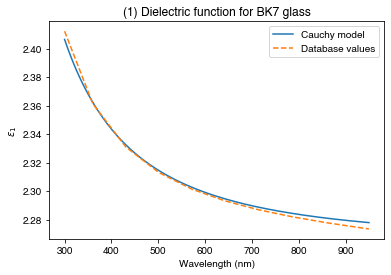

In [8]:
plt.figure()
plt.plot(wl*1e9, np.real(eps), label='Cauchy model')
plt.plot(wl*1e9, np.real(eps_db), '--', label='Database values')
plt.legend()
plt.ylabel(r'$\epsilon_1$')
plt.xlabel('Wavelength (nm)')
plt.title("(1) Dielectric function for BK7 glass")
plt.show()

Here, we have just looked at the real part of the dielectric function, but you can include absorption (non-zero
e_2) in the dielectric constant models too.

Now let's look at a more complicated CPPB (Critical Point Parabolic Band) model for GaAs. First, read in experimental data for GaAs dielectric function (from Palik)...

In [9]:
Palik_Eps1 = np.loadtxt("data/Palik_GaAs_Eps1.csv", delimiter=',', unpack=False)
Palik_Eps2 = np.loadtxt("data/Palik_GaAs_Eps2.csv", delimiter=',', unpack=False)

Generate a list of energies over which to calculate the model dielectric function and create the CPPB_model Class object:

In [10]:
E = np.linspace(0.2, 5, 1000)
CPPB_Model = Custom_CPPB()

The Material_Params method loads in the desired material parameters as a dictionary (for some common materials):

In [11]:
MatParams = CPPB_Model.Material_Params("GaAs")

Parameters can be customised by assigning to the correct dictionary key:

In [12]:
MatParams["B1"] = 5.8
MatParams["B1s"] = 1.0
MatParams["Gamma_Eg_ID"] = 0.3
MatParams["Alpha_Eg_ID"] = 0.0
MatParams["E1"] = 2.8
MatParams["E1_d1"] = 2.9
MatParams["Gamma_E1"] = 0.1
MatParams["E2"] = 4.72
MatParams["C"] = 3.0
MatParams["Alpha_E2"] = 0.04
MatParams["Gamma_E2"] = 0.19

Must define a structure object containing the required oscillator functions. The oscillator type and material parameters are both passed to individual 'Oscillators' in the structure:

In [13]:
Adachi_GaAs = Structure([
    Oscillator(oscillator_type="E0andE0_d0", material_parameters=MatParams),
    Oscillator(oscillator_type="E1andE1_d1", material_parameters=MatParams),
    Oscillator(oscillator_type="E_ID", material_parameters=MatParams),
    Oscillator(oscillator_type="E2", material_parameters=MatParams)
])

Output = CPPB_Model.eps_calc(Adachi_GaAs, E)

**PLOT 2**: real and imaginary part of the dielectric constant, showing the individual contributions of the critical points.

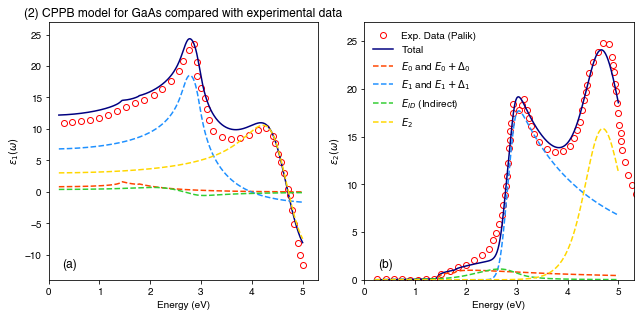

In [14]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 4.5))

# Subplot I :: Real part of the dielectric function.
ax1.set_xlim(0, 5.3)
ax1.set_ylim(-14, 27)

ax1.plot(Palik_Eps1[:, 0], Palik_Eps1[:, 1], label="Exp. Data (Palik)",
         marker='o', ls='none', markerfacecolor='none', markeredgecolor="red")

ax1.plot(E, Output["eps"].real, color="navy", label="Total")
ax1.plot(E, Output["components"][0].real, color="orangered", ls='--', label="$E_0$ and $E_0+\Delta_0$")
ax1.plot(E, Output["components"][1].real, color="dodgerblue", ls='--', label="$E_1$ and $E_1+\Delta_1$")
ax1.plot(E, Output["components"][2].real, color="limegreen", ls='--', label="$E_{ID}$ (Indirect)")
ax1.plot(E, Output["components"][3].real, color="gold", ls='--', label="$E_2$")

ax1.set_xlabel("Energy (eV)")
ax1.set_ylabel("$\epsilon_1 (\omega)$")
ax1.set_title("(2) CPPB model for GaAs compared with experimental data")
ax1.text(0.05, 0.05, '(a)', transform=ax1.transAxes, fontsize=12)

# Subplot II :: Imaginary part of the dielectric function.

ax2.plot(Palik_Eps2[:, 0], Palik_Eps2[:, 1], label="Exp. Data (Palik)",
         marker='o', ls='none', markerfacecolor='none', markeredgecolor="red")

ax2.plot(E, Output["eps"].imag, color="Navy", label="Total")
ax2.plot(E, Output["components"][0].imag, color="orangered", ls='--', label="$E_0$ and $E_0+\Delta_0$")
ax2.plot(E, Output["components"][1].imag, color="dodgerblue", ls='--', label="$E_1$ and $E_1+\Delta_1$")
ax2.plot(E, Output["components"][2].imag, color="limegreen", ls='--', label="$E_{ID}$ (Indirect)")
ax2.plot(E, Output["components"][3].imag, color="gold", ls='--', label="$E_2$")
ax2.set_xlim(0, 5.3)
ax2.set_ylim(0, 27)

ax2.set_xlabel("Energy (eV)")
ax2.set_ylabel("$\epsilon_2 (\omega)$")
ax2.text(0.05, 0.05, '(b)', transform=ax2.transAxes, fontsize=12)
ax2.legend(loc="upper left", frameon=False)
plt.tight_layout()
plt.show()